In [1]:
using Plots
include("../inference/zero_patient.jl")
include("../bp_fast.jl")
import ProgressMeter; ProgressMeter.ijulia_behavior(:append);

In [8]:
function zp_mc_bp_onegraph(T::Integer, N::Integer, λ::Real, κ::Real, γ::Real,
        nobss::AbstractVector{Int}; nsamples_mc=2*10^5, β=2)
    @assert issorted(nobss)
    @assert nobss[end] ≤ N

    auc_bp = zeros(length(nobss)); auc_mc = zeros(length(nobss))

    nobs_idx = [1:nobss[1], [nobss[i]+1:nobss[i+1] for i in 1:length(nobss)-1]...]
    observed = sample(1:N, nobss[end], replace=false)
    # sample graph
    gg = random_regular_graph(N, 3)
    g = IndexedGraph(gg)
    p⁰ = fill([1-γ, γ], N)
    sis = SIS(g, λ, κ, T; p⁰) 
    bp = mpdbp(sis)
    ϕ = bp.ϕ
    # sample one trajectory: the truth
    x, _ = onesample(bp)
    # see who are the zero patients
    true_zp = findall(isequal(I), x[:,1]) 
    # sample from the prior for monte carlo
    sms = sample(bp, nsamples_mc; showprogress=false)
    
    for j in eachindex(nobss)
        for i in observed[nobs_idx[j]]
            xᵢᵀ = x[i,end]
            # add new observations
            ϕ[i][end] .= softmax(β, 2, xᵢᵀ)
            for (s, x_mc) in enumerate(sms.X)
                xᵢᵀ = x_mc[i,end]
                # update soft margin weights
                sms.w[s] *= ϕ[i][end][xᵢᵀ]
            end
        end
        # run bp
        guess_bp, _ = find_zero_patients_bp(bp; showprogress=false, svd_trunc=TruncBond(5))
        guess_mc, _, _ = find_zero_patients_mc(bp; sms)
        auc_bp[j] = auc(guess_bp, true_zp); auc_mc[j] = auc(guess_mc, true_zp)
    end
    auc_bp, auc_mc
end

zp_mc_bp_onegraph (generic function with 1 method)

In [9]:
T = 5
N = 10
k = 4
λ = 0.1
κ = 0.08
γ = 3/N
nobss = 2:2:N;

In [10]:
aucs_bp = Vector{Float64}[]
aucs_mc = Vector{Float64}[];

In [11]:
ninstances = 50
nsamples_mc = 10^5
for n in 1:ninstances
    println("### instance $n of $ninstances")
    auc_bp, auc_mc = zp_mc_bp_onegraph(T, N, λ, κ, γ, nobss; nsamples_mc)
    push!(aucs_bp, auc_bp)
    push!(aucs_mc, auc_mc)
    flush(stdout)
end

### instance 1 of 50
### instance 2 of 50
### instance 3 of 50
### instance 4 of 50
### instance 5 of 50
### instance 6 of 50
### instance 7 of 50
### instance 8 of 50
### instance 9 of 50
### instance 10 of 50
### instance 11 of 50
### instance 12 of 50
### instance 13 of 50
### instance 14 of 50
### instance 15 of 50
### instance 16 of 50
### instance 17 of 50
### instance 18 of 50
### instance 19 of 50
### instance 20 of 50
### instance 21 of 50
### instance 22 of 50
### instance 23 of 50
### instance 24 of 50
### instance 25 of 50
### instance 26 of 50
### instance 27 of 50
### instance 28 of 50
### instance 29 of 50
### instance 30 of 50
### instance 31 of 50
### instance 32 of 50
### instance 33 of 50
### instance 34 of 50
### instance 35 of 50
### instance 36 of 50
### instance 37 of 50
### instance 38 of 50
### instance 39 of 50
### instance 40 of 50
### instance 41 of 50
### instance 42 of 50
### instance 43 of 50
### instance 44 of 50
### instance 45 of 50
### instance 46 of 

SIS with: P(S→I)=λ=0.1, P(I→S)=κ=0.08. P(zero patient)=γ=0.3
Random regular N=10, k=4. T=5, 10 random observations from the prior at final time
Average over 50 instances


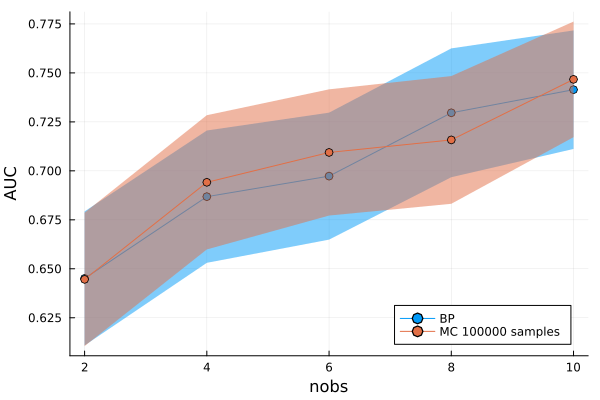

In [12]:
aucs_bp_avg = mean(aucs_bp)
aucs_bp_std = std(aucs_bp) ./ sqrt(length(aucs_bp))
aucs_mc_avg = mean(aucs_mc)
aucs_mc_std = std(aucs_mc) ./ sqrt(length(aucs_mc))

println("SIS with: P(S→I)=λ=$λ, P(I→S)=κ=$κ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=$k. T=$T, $N random observations from the prior at final time")
println("Average over ", length(aucs_bp), " instances")

pl = plot(xlabel="nobs", ylabel="AUC", xticks=nobss, legend=:bottomright)
plot!(pl, nobss, aucs_bp_avg, ribbon=aucs_bp_std, label="BP", m=:o)
plot!(pl, nobss, aucs_mc_avg, ribbon=aucs_mc_std, label="MC $nsamples_mc samples", m=:o)